<a href="https://colab.research.google.com/github/Varshith022006/explanible_ai_lab/blob/main/assignment_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 18.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=fffe1197c7d3e0d1ba3c17957768c1dc15e4a92d3830ab993b013d649dc5c4c6
  Stored in directory: /root/.cache/pip/wheels/e7/5d/0e/4b4fff9a47468fed5633211fb3b76d1db43fe806a17fb7486a
Successfully built lime
Dataset shape: (1797, 64) Labels: (1797,)
X_train shape: (1347, 64)
X_test shape: (450, 64)
RF trained. Test accuracy: 0.967


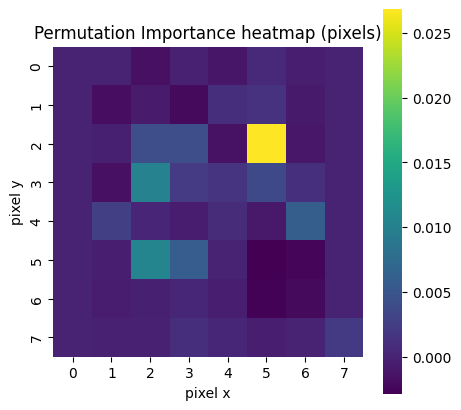

Shapes of shap_values per class:
 Class 0: (64, 10)
 Class 1: (64, 10)
 Class 2: (64, 10)
 Class 3: (64, 10)
 Class 4: (64, 10)
 Class 5: (64, 10)
 Class 6: (64, 10)
 Class 7: (64, 10)
 Class 8: (64, 10)
 Class 9: (64, 10)
 Class 10: (64, 10)
 Class 11: (64, 10)
 Class 12: (64, 10)
 Class 13: (64, 10)
 Class 14: (64, 10)
 Class 15: (64, 10)
 Class 16: (64, 10)
 Class 17: (64, 10)
 Class 18: (64, 10)
 Class 19: (64, 10)
 Class 20: (64, 10)
 Class 21: (64, 10)
 Class 22: (64, 10)
 Class 23: (64, 10)
 Class 24: (64, 10)
 Class 25: (64, 10)
 Class 26: (64, 10)
 Class 27: (64, 10)
 Class 28: (64, 10)
 Class 29: (64, 10)
 Class 30: (64, 10)
 Class 31: (64, 10)
 Class 32: (64, 10)
 Class 33: (64, 10)
 Class 34: (64, 10)
 Class 35: (64, 10)
 Class 36: (64, 10)
 Class 37: (64, 10)
 Class 38: (64, 10)
 Class 39: (64, 10)
 Class 40: (64, 10)
 Class 41: (64, 10)
 Class 42: (64, 10)
 Class 43: (64, 10)
 Class 44: (64, 10)
 Class 45: (64, 10)
 Class 46: (64, 10)
 Class 47: (64, 10)
 Class 48: (64, 1

In [1]:
!pip install scikit-learn matplotlib seaborn shap lime joblib

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import load_digits
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.inspection import permutation_importance
import shap
from lime.lime_tabular import LimeTabularExplainer
import os
import joblib

os.makedirs('outputs', exist_ok=True)

digits = load_digits()
X = digits.data  # shape (n_samples, 64)
y = digits.target
feature_names = [f'px_{i}' for i in range(X.shape[1])]

print("Dataset shape:", X.shape, "Labels:", y.shape)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.25, random_state=42
)
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)


rf = RandomForestClassifier(n_estimators=200, random_state=42)
rf.fit(X_train, y_train)
print('RF trained. Test accuracy: {:.3f}'.format(rf.score(X_test, y_test)))

r = permutation_importance(rf, X_test, y_test, n_repeats=30, random_state=42, n_jobs=-1)
pi_mean = r.importances_mean  # length 64

pi_map = pi_mean.reshape(8,8)
plt.figure(figsize=(5,5))
plt.title('Permutation Importance heatmap (pixels)')
ax = sns.heatmap(pi_map, annot=False, cmap='viridis', square=True)
plt.xlabel('pixel x')
plt.ylabel('pixel y')
plt.savefig('outputs/pi_heatmap.png', bbox_inches='tight')
plt.show()


explainer = shap.TreeExplainer(rf)
shap_values = explainer.shap_values(X_test)  # list of arrays for each class

print("Shapes of shap_values per class:")
for i, sv in enumerate(shap_values):
    print(f" Class {i}: {sv.shape}")

shap_values_stacked = np.stack(shap_values, axis=0)
print("shap_values_stacked shape:", shap_values_stacked.shape)

shap_array_abs = np.sum(np.abs(shap_values_stacked), axis=0)
print("shap_array_abs shape:", shap_array_abs.shape)

if shap_array_abs.shape[1] == X_test.shape[1]:
    plt.figure()
    shap.summary_plot(shap_array_abs, X_test, feature_names=feature_names, show=False)
    plt.savefig('outputs/shap_beeswarm_aggregated.png', bbox_inches='tight')
    plt.close()
    print(" SHAP beeswarm saved.")
else:
    print(" Shape mismatch: cannot plot beeswarm.")

# ---- SHAP heatmap ----
if shap_array_abs.shape[1] == 64:
    shap_mean_abs = np.mean(shap_array_abs, axis=0).reshape(8,8)
    plt.figure(figsize=(5,5))
    plt.title('Mean absolute SHAP values heatmap (pixels)')
    sns.heatmap(shap_mean_abs, annot=False, cmap='magma', square=True)
    plt.xlabel('pixel x')
    plt.ylabel('pixel y')
    plt.savefig('outputs/shap_heatmap.png', bbox_inches='tight')
    plt.show()
    print("SHAP heatmap saved.")
else:
    print(" shap_array_abs is not 64 features, got:", shap_array_abs.shape[1])